In [26]:
# Load the necessary libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.models import Model


In [ ]:
#Download the dataset from onedrive link to the "Glaucoma_Dataset"
# !wget -r -P Dataset_Glaucoma https://onedrive.live.com/?authkey=%21AJzdvMkOvrSXTeI&id=D25A5DC53B5C17C1%2132853&cid=D25A5DC53B5C17C1

In [36]:
# Path to the downloaded dataset
dataset_dir = '/content/drive/MyDrive/Dataset_Glaucoma'

In [37]:
# Define image and model parameters
input_size = (299, 299)
num_classes = 2
batch_size= 32

In [38]:
# Function to convert images to grayscale
def to_grayscale(image):
    image = cv2.imread(image,cv2.COLOR_BGR2GRAY)
    return image

In [39]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=to_grayscale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    #class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    dataset_dir, # same directory as training data
    target_size=input_size,
    batch_size=batch_size,
    #class_mode='binary',
    subset='validation') # set as validation data

Found 521 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [23]:
# A function to display random images from the dataset
def view_images(folder_path, num_images=5):
  """Views the first `num_images` images from a folder.

  Args:
    folder_path: The path to the folder containing the images.
    num_images: The number of images to view.
  """

  # Get the list of images in the folder.
  image_files = os.listdir(folder_path)

  # Create a figure and a set of subplots.
  fig, axs = plt.subplots(1, num_images, figsize=(20, 10))

  # View the first `num_images` images in the subplots.
  for i in range(num_images):
    image_file = image_files[i]
    image_path = os.path.join(folder_path, image_file)
    image = plt.imread(image_path)
    axs[i].imshow(image)
    axs[i].set_title(image_file)
    axs[i].axis('off')

  # Show the figure.
  plt.show()


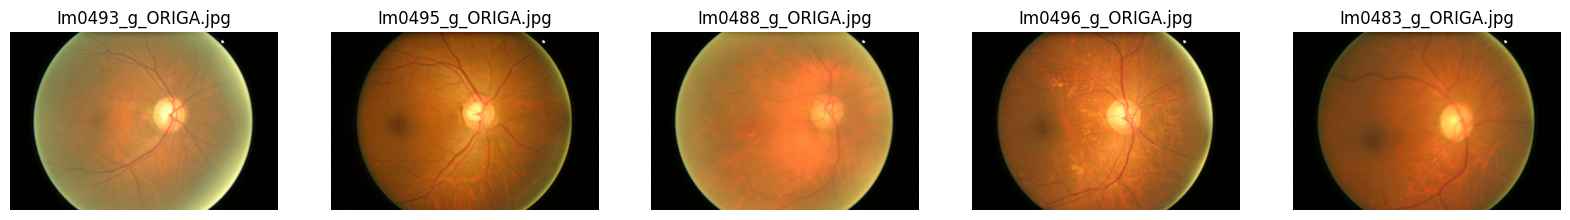

In [24]:
# View 5 images from the Glaucoma folder.
view_images("/content/drive/MyDrive/Dataset_Glaucoma/glaucoma", num_images=5)

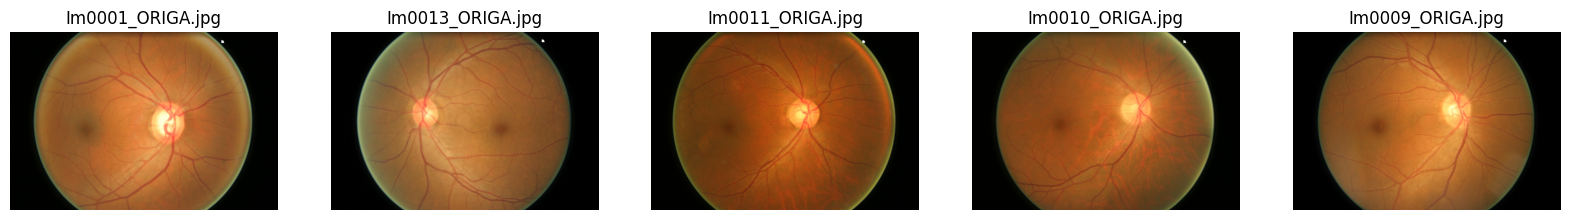

In [25]:
# View 5 images from the sanas folder.
view_images("/content/drive/MyDrive/Dataset_Glaucoma/sanas", num_images=5)

In [ ]:
# Load pre-trained Xception model
base_model = Xception(input_shape=input_size + (3,), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add a feature extraction layer
feature_extractor = Flatten()(base_model.output)  # Flatten the output

# Add custom layers on top of the feature extractor
x = Dense(128, activation='relu')(feature_extractor)  # Additional dense layer
x = Dense(64, activation='relu')(x)   # Additional dense layer
predictions = Dense(2, activation='softmax')(x)  # Binary classification output

# Create the new model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
20/20 [==============================] - 447s 22s/step - loss: 4.8565 - accuracy: 0.6857 - val_loss: 1.0352 - val_accuracy: 0.6991
Epoch 2/10
20/20 [==============================] - 425s 22s/step - loss: 0.8441 - accuracy: 0.7671 - val_loss: 0.6924 - val_accuracy: 0.8009
Epoch 3/10
20/20 [==============================] - 384s 19s/step - loss: 0.4504 - accuracy: 0.8339 - val_loss: 0.3312 - val_accuracy: 0.9115
Epoch 4/10
20/20 [==============================] - 426s 21s/step - loss: 0.3335 - accuracy: 0.8827 - val_loss: 0.3534 - val_accuracy: 0.8717
Epoch 5/10
20/20 [==============================] - 438s 22s/step - loss: 0.1769 - accuracy: 0.9267 - val_loss: 0.1264 - val_accuracy: 0.9558
Epoch 6/10
20/20 [==============================] - 435s 22s/step - loss: 0.1018 - accuracy: 0.9691 - val_loss: 0.1766 - val_accuracy: 0.9381
Epoch 7/10
20/20 [==============================] - 433s 22s/step - loss: 0.0775 - accuracy: 0.9707 - val_loss: 0.1185 - val_accuracy: 0.9690
Epoch 

In [ ]:
# Evaluate the model
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
#roc_auc = roc_auc_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))

#print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)

8/8 [==============================] - 109s 13s/step
Confusion Matrix:
[[ 18  42]
 [ 44 122]]


In [ ]:
[[tn, fp], [fn, tp]]= conf_matrix

In [ ]:
# Evaluate the model
auc = roc_auc_score(y_true, y_pred.argmax(axis=1))
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


AUC: 0.5174698795180723
Sensitivity: 0.7349397590361446
Specificity: 0.3


Now Define a function to calculate the 95% confidence interval of the evaluation score using standard method. Alternatively 95% CI can be calculated using bootstraping method for better reliability.

In [ ]:
def calculate_confidence_interval(sensitivity, specificity, sample_size):
  """Calculates the 95% confidence interval for the sensitivity and specificity of a diagnostic test.

  Args:
    sensitivity: The sensitivity of the diagnostic test.
    specificity: The specificity of the diagnostic test.
    sample_size: The sample size of the study.

  Returns:
    A tuple of two tuples, where the first tuple contains the 95% confidence interval for the sensitivity and the second tuple contains the 95% confidence interval for the specificity.
  """

  # Calculate the standard error of the sensitivity and specificity.
  se_sensitivity = np.sqrt(sensitivity * (1 - sensitivity) / sample_size)
  se_specificity = np.sqrt(specificity * (1 - specificity) / sample_size)

  # Calculate the 95% confidence interval for the sensitivity and specificity.
  ci_sensitivity = (sensitivity - 1.96 * se_sensitivity, sensitivity + 1.96 * se_sensitivity)
  ci_specificity = (specificity - 1.96 * se_specificity, specificity + 1.96 * se_specificity)

  return ci_sensitivity, ci_specificity

In [ ]:
# Calculate the 95% confidence interval for the AUC, Sensitivity, and specificity
ci_auc = calculate_confidence_interval(auc, 0.5, len(y_true))
ci_sensitivity = calculate_confidence_interval(sensitivity, 0.5, len(y_true))
ci_specificity = calculate_confidence_interval(specificity, 0.5, len(y_true))

# Print the results
print("AUC:", auc, "(95% CI:", ci_auc[0], ",", ci_auc[1], ")")
print("Sensitivity:", sensitivity, "(95% CI:", ci_sensitivity[0], ",", ci_sensitivity[1], ")")
print("Specificity:", specificity, "(95% CI:", ci_specificity[0], ",", ci_specificity[1], ")")

In [ ]:
# Save the model
model.save('glaucoma_model.h5')

In [ ]:
# Fine tuning
import keras
base_model.trainable = True
model.summary()

model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Save the model
model.save('glaucoma_model_fine tuned.h5')